In [4]:
# !pip install transformers
# !pip install datasets
# !pip install evaluate
# !pip install "tf-models-official==2.13.*"

#https://medium.com/geekculture/hugging-face-distilbert-tensorflow-for-custom-text-classification-1ad4a49e26a7

In [36]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
import numpy as np
from official.nlp import optimization

#MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
#MODEL_NAME = 'distilbert-base-cased'
MODEL_NAME= 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

def label_mapping(example):
    mapping={
        "DECEPTIVENEGATIVE":0,
        "DECEPTIVEPOSITIVE":1,
        "TRUTHFULNEGATIVE":2,
        "TRUTHFULPOSITIVE":3,
    }
    return {"label":mapping[example["label"]]}


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

def train_pre_processing(txt_file):
  df=pd.read_csv(txt_file,sep="\t",names=["LABEL","REVIEW"])
  dataset = Dataset.from_pandas(df)
  dataset=dataset.rename_columns({"LABEL":"label","REVIEW":"text"})
  dataset=dataset.train_test_split(test_size=0.2,shuffle=True)

  dataset=dataset.map(label_mapping,batched=False)
  tokenized_datasets = dataset.map(tokenize_function, batched=True)
  tokenized_datasets = tokenized_datasets.remove_columns(["text"])
  tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
  return tokenized_datasets

def test_pre_processing(txt_file):
  with open(txt_file, "r") as file:
      content = file.read()
  content=content.splitlines()
  df=pd.DataFrame(content,columns=["REVIEW"])
  dataset = Dataset.from_pandas(df)
  dataset=dataset.rename_columns({"REVIEW":"text"})
  tokenized_datasets = dataset.map(tokenize_function, batched=True)
  tokenized_datasets = tokenized_datasets.remove_columns(["text"])
  return tokenized_datasets

def get_predictions(model,dataset):
  preds=model.predict(dataset)
  return np.argmax(preds.logits,axis=1)


#tokenized_datasets["train"] = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
#tokenized_datasets["test"] = tokenized_datasets["test"].shuffle(seed=42).select(range(10))

In [40]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification

from transformers import DefaultDataCollator
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
import numpy as np
from official.nlp import optimization
from sklearn.metrics import accuracy_score


seed=812
tf.keras.utils.set_random_seed(seed)

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=4)

batch_size=8
epochs=6

data_collator = DefaultDataCollator(return_tensors="tf")
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
tokenized_datasets=train_pre_processing("train.txt")

tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)

tf_validation_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)


2023-10-24 18:23:11.335051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 18:23:11.351107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 18:23:11.351156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 18:23:11.353896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 18:23:11.353959: I tensorflow/compile

In [7]:
steps_per_epoch = tf.data.experimental.cardinality(tf_train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

model.compile(
    #optimizer=tf.keras.optimizers.AdamW(init_lr),
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

# loss, acc=model.evaluate(tf_validation_dataset)
# print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


In [8]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66956548 (255.42 MB)
Trainable params: 66956548 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
import os
optimizer_type='customized'
#optimizer_type='adamW'
save_model_dir=os.path.join(os.getcwd(),f"model_seed_{seed}_epcs_{epochs}_bs_{batch_size}_lr_{init_lr}_opt_{optimizer_type}")
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
             tf.keras.callbacks.ModelCheckpoint(filepath=save_model_dir, monitor='val_loss',save_best_only=True,save_weights_only=True)]
H=model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=epochs,callbacks=callbacks)

Epoch 1/6
140/140 [==============================] - 56s 340ms/step - loss: 1.0540 - sparse_categorical_accuracy: 0.5241 - val_loss: 0.6920 - val_sparse_categorical_accuracy: 0.6679
Epoch 2/6
140/140 [==============================] - 47s 336ms/step - loss: 0.4770 - sparse_categorical_accuracy: 0.8259 - val_loss: 0.5875 - val_sparse_categorical_accuracy: 0.7500
Epoch 3/6
140/140 [==============================] - 46s 331ms/step - loss: 0.2593 - sparse_categorical_accuracy: 0.9134 - val_loss: 0.6075 - val_sparse_categorical_accuracy: 0.7750
Epoch 4/6
140/140 [==============================] - 48s 343ms/step - loss: 0.1055 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.3550 - val_sparse_categorical_accuracy: 0.8893
Epoch 5/6
140/140 [==============================] - 49s 347ms/step - loss: 0.0328 - sparse_categorical_accuracy: 0.9929 - val_loss: 0.3240 - val_sparse_categorical_accuracy: 0.9000
Epoch 6/6
140/140 [==============================] - 47s 337ms/step - loss: 0.0203 - spars

In [30]:
model.save_weights('my_model_weights.h5')

In [41]:
saved_model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=4)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [45]:
saved_model.load_weights("saved_models/model_1_0.9/cp.ckpt")

In [13]:
preds=get_predictions(saved_model,tf_validation_dataset)

35/35 [==============================] - 5s 101ms/step


In [14]:
accuracy_score(tokenized_datasets["test"]["labels"],preds)

0.9

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


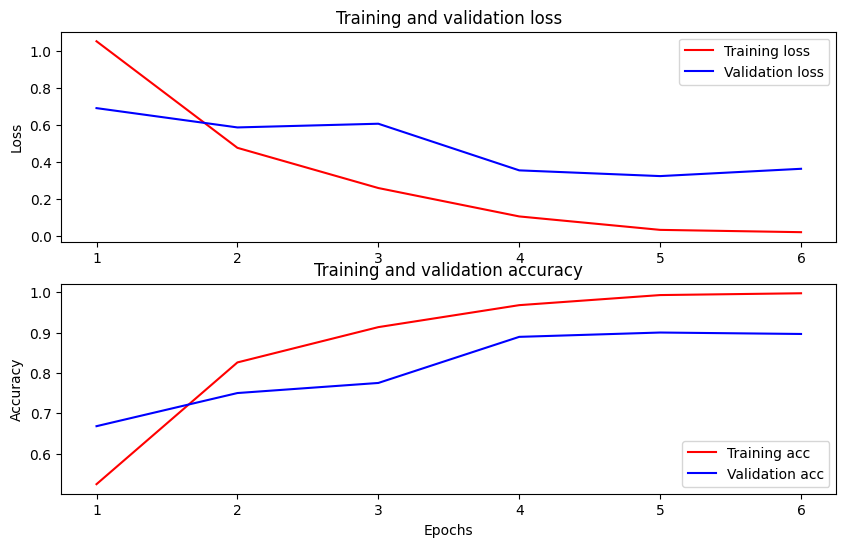

In [16]:
history_dict = H.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
print(tf_validation_dataset)

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [6]:
import pandas as pd
import os

In [47]:
test_tokenized=test_pre_processing("test_just_reviews.txt")

tf_test_dataset = test_tokenized.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

Map: 100%|██████████| 200/200 [00:00<00:00, 566.09 examples/s]


In [49]:
preds=get_predictions(saved_model,tf_test_dataset)

25/25 [==============================] - 3s 100ms/step


In [58]:
def reverse_mapping(preds):
    mapping={
        0:"DECEPTIVENEGATIVE",
        1:"DECEPTIVEPOSITIVE",
        2:"TRUTHFULNEGATIVE",
        3:"TRUTHFULPOSITIVE",
    }
    return [mapping[pred] for pred in preds]

preds_labels=reverse_mapping(preds)
np.save("test_labels",np.array(preds_labels))
#np.load("test_labels.npy")


['DECEPTIVEPOSITIVE' 'DECEPTIVENEGATIVE' 'DECEPTIVEPOSITIVE'
 'TRUTHFULPOSITIVE' 'TRUTHFULPOSITIVE' 'TRUTHFULNEGATIVE'
 'DECEPTIVEPOSITIVE' 'DECEPTIVEPOSITIVE' 'TRUTHFULNEGATIVE'
 'DECEPTIVENEGATIVE' 'DECEPTIVEPOSITIVE' 'DECEPTIVEPOSITIVE'
 'TRUTHFULNEGATIVE' 'TRUTHFULNEGATIVE' 'TRUTHFULPOSITIVE'
 'DECEPTIVEPOSITIVE' 'TRUTHFULPOSITIVE' 'TRUTHFULPOSITIVE'
 'DECEPTIVENEGATIVE' 'TRUTHFULPOSITIVE' 'DECEPTIVEPOSITIVE'
 'DECEPTIVEPOSITIVE' 'DECEPTIVEPOSITIVE' 'DECEPTIVENEGATIVE'
 'DECEPTIVEPOSITIVE' 'DECEPTIVENEGATIVE' 'TRUTHFULPOSITIVE'
 'TRUTHFULPOSITIVE' 'TRUTHFULNEGATIVE' 'DECEPTIVENEGATIVE'
 'TRUTHFULPOSITIVE' 'DECEPTIVEPOSITIVE' 'DECEPTIVEPOSITIVE'
 'DECEPTIVENEGATIVE' 'TRUTHFULNEGATIVE' 'DECEPTIVENEGATIVE'
 'TRUTHFULPOSITIVE' 'DECEPTIVEPOSITIVE' 'TRUTHFULNEGATIVE'
 'DECEPTIVENEGATIVE' 'TRUTHFULPOSITIVE' 'TRUTHFULNEGATIVE'
 'DECEPTIVENEGATIVE' 'TRUTHFULPOSITIVE' 'DECEPTIVENEGATIVE'
 'TRUTHFULNEGATIVE' 'DECEPTIVENEGATIVE' 'DECEPTIVENEGATIVE'
 'DECEPTIVENEGATIVE' 'DECEPTIVEPOSITIVE' 'TRU

In [67]:
with open("test_just_reviews.txt", "r") as file:
    content = file.read()
content=content.splitlines()
df=pd.DataFrame(content,columns=["REVIEWS"])
df["LABEL"]=preds_labels
df= df.loc[:, ::-1] 
df.to_csv("test_reviews_and_labels.csv",sep="\t",index=False)